In [1]:
import os

import numpy as np
import pandas as pd

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

import matplotlib.pyplot as plt
import cv2
import scipy
import scipy.io

Using TensorFlow backend.


In [2]:
# Suppress warning and informational messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
# Get count of number of files in this folder and all subfolders
def get_num_files(path):
  if not os.path.exists(path):
    return 0
  return sum([len(files) for r, d, files in os.walk(path)])

In [4]:
# Get count of number of subfolders directly below the folder in path
def get_num_subfolders(path):
  if not os.path.exists(path):
    return 0
  return sum([len(d) for r, d, files in os.walk(path)])

In [5]:
#   Define image generators that will variations of image with the image r/otated slightly, shifted up, down, left, or right, 
#     sheared, zoomed in, or flipped horizontally on the vertical axis (ie. person looking to the left ends up looking to the right)
def create_img_generator():
  return  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True
  )

In [6]:
# Main Code
Image_width, Image_height = 299, 299 
Training_Epochs = 8
Batch_Size = 32
Number_FC_Neurons = 1024

train_dir = r'./../Storage/train'
validate_dir = r'./../Storage/valid'
num_train_samples = get_num_files(train_dir) 
num_classes = get_num_subfolders(train_dir)
num_validate_samples = get_num_files(validate_dir)
num_epoch = Training_Epochs
batch_size = Batch_Size

In [7]:
# Define data pre-processing 
#   Define image generators for training and testing 
train_image_gen = create_img_generator()
test_image_gen = create_img_generator()

In [8]:
#   Connect the image generator to a folder contains the source images the image generator alters.  
#   Training image generator
train_generator = train_image_gen.flow_from_directory(
  train_dir,
  target_size=(Image_width, Image_height),
  batch_size=batch_size,
  seed = 42    #set seed for reproducability
)

Found 6552 images belonging to 102 classes.


In [9]:
#   Validation image generator
validation_generator = test_image_gen.flow_from_directory(
  validate_dir,
  target_size=(Image_width, Image_height),
  batch_size=batch_size,
  seed=42       #set seed for reproducability
)

Found 818 images belonging to 102 classes.


In [10]:
# Load the Inception V3 model and load it with it's pre-trained weights.  But exclude the final 
#    Fully Connected layer
InceptionV3_base_model = InceptionV3(weights='imagenet', include_top=False) #include_top=False excludes final FC layer
print('Inception v3 base model without last FC loaded')
#print(InceptionV3_base_model.summary())     # display the Inception V3 model hierarchy

Inception v3 base model without last FC loaded


In [11]:
# Define the layers in the new classification prediction 
x = InceptionV3_base_model.output
x = GlobalMaxPooling2D()(x)
x = Dense(Number_FC_Neurons, activation='relu')(x)        # new FC layer, random init
predictions = Dense(num_classes, activation='softmax')(x)  # new softmax layer

In [12]:
# Define trainable model which links input from the Inception V3 base model to the new classification prediction layers
model = Model(inputs=InceptionV3_base_model.input, outputs=predictions)

In [13]:
# print model structure diagram
print (model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [14]:
# Option 1: Basic Transfer Learning
print ('\nPerforming Transfer Learning')
  #   Freeze all layers in the Inception V3 base model 
for layer in InceptionV3_base_model.layers:
  layer.trainable = False


Performing Transfer Learning


In [14]:
len(model.layers)

314

In [15]:
#   Define model compile for basic Transfer Learning
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Fit the transfer learning model to the data from the generators.  
# By using generators we can ask continue to request sample images and the generators will pull images from 
# the training or validation folders and alter them slightly
history_transfer_learning = model.fit_generator(
  train_generator,
  epochs=num_epoch,
  steps_per_epoch = num_train_samples // batch_size,
  validation_data=validation_generator,
  validation_steps = num_validate_samples // batch_size,
  class_weight='auto')

Epoch 1/8
204/204 [==============================] - 147s 719ms/step - loss: 4.7732 - accuracy: 0.1808 - val_loss: 4.1635 - val_accuracy: 0.1525
Epoch 2/8
204/204 [==============================] - 133s 650ms/step - loss: 2.3241 - accuracy: 0.4479 - val_loss: 3.3337 - val_accuracy: 0.1578
Epoch 3/8
204/204 [==============================] - 141s 691ms/step - loss: 1.6273 - accuracy: 0.5775 - val_loss: 4.6096 - val_accuracy: 0.2099
Epoch 4/8
204/204 [==============================] - 124s 610ms/step - loss: 1.3486 - accuracy: 0.6396 - val_loss: 3.2610 - val_accuracy: 0.2468
Epoch 5/8
204/204 [==============================] - 124s 609ms/step - loss: 1.1976 - accuracy: 0.6781 - val_loss: 2.7479 - val_accuracy: 0.2341
Epoch 6/8
204/204 [==============================] - 122s 600ms/step - loss: 1.0567 - accuracy: 0.7083 - val_loss: 3.5179 - val_accuracy: 0.2863
Epoch 7/8
204/204 [==============================] - 122s 597ms/step - loss: 1.0040 - accuracy: 0.7225 - val_loss: 2.7159 - val_ac

dict_keys(['loss', 'val_loss', 'val_accuracy', 'accuracy'])


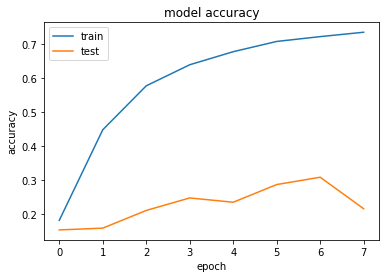

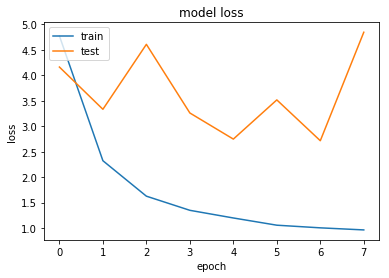

In [17]:
# list all data in history
print(history_transfer_learning.history.keys())
# summarize history for accuracy
plt.plot(history_transfer_learning.history['accuracy'])
plt.plot(history_transfer_learning.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_transfer_learning.history['loss'])
plt.plot(history_transfer_learning.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
# Save transfer learning model
model.save('inceptionv3-transfer-learning.model')

In [19]:
model = load_model('inceptionv3-transfer-learning.model')

In [20]:
# Option 2: Transfer Learning with Fine-tuning - retrain the end few layers (called the top layers) of the inception model
print('\nFine tuning existing model')
#   Freeze 
Layers_To_Freeze = 172
for layer in model.layers[:Layers_To_Freeze]:
  layer.trainable = False
for layer in model.layers[Layers_To_Freeze:]:
  layer.trainable = True
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])


Fine tuning existing model


In [21]:
# Fit the Fine-tuning model to the data from the generators.  
# By using generators we can ask continue to request sample images and the generators will pull images from the training or validation
# folders, alter then slightly, and pass the images back
history_fine_tune = model.fit_generator(
  train_generator,
  steps_per_epoch = num_train_samples // batch_size,
  epochs=num_epoch,
  validation_data=validation_generator,
  validation_steps = num_validate_samples // batch_size,
    class_weight='auto')

Epoch 1/8
204/204 [==============================] - 164s 803ms/step - loss: 0.5362 - accuracy: 0.8488 - val_loss: 2.0515 - val_accuracy: 0.6413
Epoch 2/8
204/204 [==============================] - 152s 745ms/step - loss: 0.4128 - accuracy: 0.8801 - val_loss: 1.0004 - val_accuracy: 0.7048
Epoch 3/8
204/204 [==============================] - 152s 747ms/step - loss: 0.3361 - accuracy: 0.9067 - val_loss: 0.8310 - val_accuracy: 0.7417
Epoch 4/8
204/204 [==============================] - 152s 747ms/step - loss: 0.2845 - accuracy: 0.9236 - val_loss: 0.7342 - val_accuracy: 0.7672
Epoch 5/8
204/204 [==============================] - 153s 748ms/step - loss: 0.2623 - accuracy: 0.9233 - val_loss: 0.7428 - val_accuracy: 0.7557
Epoch 6/8
204/204 [==============================] - 152s 743ms/step - loss: 0.2287 - accuracy: 0.9396 - val_loss: 1.1004 - val_accuracy: 0.7557
Epoch 7/8
204/204 [==============================] - 152s 745ms/step - loss: 0.2088 - accuracy: 0.9422 - val_loss: 0.4643 - val_ac

In [22]:
# Save fine tuned model
model.save('inceptionv3-fine-tune.model')

dict_keys(['loss', 'val_loss', 'val_accuracy', 'accuracy'])


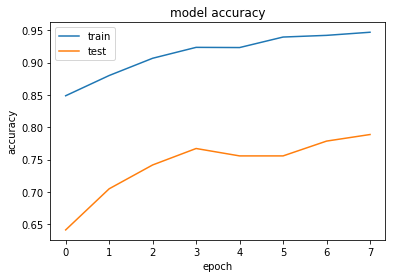

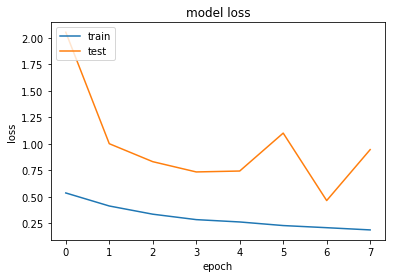

In [23]:
# list all data in history
print(history_fine_tune.history.keys())
# summarize history for accuracy
plt.plot(history_fine_tune.history['accuracy'])
plt.plot(history_fine_tune.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_fine_tune.history['loss'])
plt.plot(history_fine_tune.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
#   Validation image generator
test_datagen = ImageDataGenerator()
test_dir = r'./../Storage/test'

In [39]:
#   Validation image generator
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(Image_width, Image_height),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 819 images belonging to 1 classes.


In [40]:
test_generator.reset()

In [41]:
filenames = test_generator.filenames
nb_samples = len(filenames)

In [45]:
pred=model.predict_generator(test_generator,verbose=1,steps = np.ceil(nb_samples/batch_size))

26/26 [==============================] - 20s 757ms/step


In [46]:
predicted_class_indices=np.argmax(pred,axis=1)

In [47]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [50]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

In [51]:
results

,Filename,Predictions
0,test\image_00005.jpg,89
1,test\image_00006.jpg,73
2,test\image_00024.jpg,96
3,test\image_00025.jpg,30
4,test\image_00029.jpg,96
...,...,...
814,test\image_08133.jpg,89
815,test\image_08134.jpg,88
816,test\image_08144.jpg,88
817,test\image_08172.jpg,78


In [88]:
type(results.Predictions.loc[1])

str

In [89]:
results.Predictions = results.Predictions.astype(np.int64)

In [90]:
type(results.Predictions.loc[1])

numpy.int64

In [91]:
results

,Filename,Predictions
0,test\image_00005.jpg,89
1,test\image_00006.jpg,73
2,test\image_00024.jpg,96
3,test\image_00025.jpg,30
4,test\image_00029.jpg,96
...,...,...
814,test\image_08133.jpg,89
815,test\image_08134.jpg,88
816,test\image_08144.jpg,88
817,test\image_08172.jpg,78


In [52]:
#oxford102_flower_dataset_labels.txt contains a dataset where index is the unique label and column "Names" is the name of the flower for the image label id 
#read labels from oxford102_flower_dataset_labels.txt
oxford102_labels = pd.read_csv('oxford102_flower_dataset_labels.txt', delimiter='\t', header=None, names=['Names'])
# Image labels are 1 based, changed the index of the image database label
oxford102_labels.index = np.arange(1, len(oxford102_labels) + 1)
print(oxford102_labels)
print()
print("Test Print: FLower Name and its unique label")
print(oxford102_labels.loc[77])

                            Names
1                 'pink primrose'
2     'hard-leaved pocket orchid'
3              'canterbury bells'
4                     'sweet pea'
5              'english marigold'
..                            ...
98              'mexican petunia'
99                     'bromelia'
100              'blanket flower'
101             'trumpet creeper'
102             'blackberry lily'

[102 rows x 1 columns]

Test Print: FLower Name and its unique label
Names     'passion flower'
Name: 77, dtype: object


In [75]:
oxford102_labels.reset_index(level=0, inplace=True)

In [76]:
oxford102_labels.head()

,index,Names
0,1,'pink primrose'
1,2,'hard-leaved pocket orchid'
2,3,'canterbury bells'
3,4,'sweet pea'
4,5,'english marigold'


In [84]:
oxford102_labels.rename({'index': 'Predictions'}, axis=1, inplace=True)

In [85]:
oxford102_labels.columns

Index(['Predictions', 'Names'], dtype='object')

In [92]:
merge_predictions = pd.merge(results, oxford102_labels, on='Predictions')

In [93]:
merge_predictions

,Filename,Predictions,Names
0,test\image_00005.jpg,89,'watercress'
1,test\image_00099.jpg,89,'watercress'
2,test\image_00202.jpg,89,'watercress'
3,test\image_00282.jpg,89,'watercress'
4,test\image_00324.jpg,89,'watercress'
...,...,...,...
814,test\image_06460.jpg,44,'poinsettia'
815,test\image_07234.jpg,44,'poinsettia'
816,test\image_07090.jpg,4,'sweet pea'
817,test\image_07250.jpg,27,'prince of wales feathers'


In [95]:
merge_predictions.loc[merge_predictions['Filename'] == 'test\image_00006.jpg']

,Filename,Predictions,Names
65,test\image_00006.jpg,73,'water lily'


In [97]:
oxford102_labels.loc[72]

Predictions               73
Names           'water lily'
Name: 72, dtype: object

In [102]:
#imagelabels.mat contains labels of the images and number of images for each label
#labels and unique are the lists that contain the label ids and respective number of images 
mat = scipy.io.loadmat('imagelabels.mat')
labels = mat['labels'].tolist()
unique, counts = np.unique(labels, return_counts=True)

In [103]:
#find a flower label from flower image name
def find_flower_label_from_flower_image_name(flower_image_name):
    flower_id = flower_image_name.split('_')[1].split('.')[0]
    flower_id_int = int(flower_id)
    return labels[0][flower_id_int - 1]

In [134]:
#Find the name of the flower from the image name from the image database
def find_flower_category_name(file_path):
    flower_name = file_path.split("\\")[-1]
    flower_label = find_flower_label_from_flower_image_name(flower_name)
    flower_category_name = oxford102_labels.Names.loc[flower_label]
    return flower_category_name.replace("'", '').strip()

In [135]:
find_flower_category_name('test\image_00006.jpg')

'lotus'